In [132]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
import pywt
from sklearn.preprocessing import MinMaxScaler
from torch.cuda import FloatTensor

# Req for package
sys.path.append("../")
from SkinLearning.Utils.NN import train, test, DEVICE, getParameterLoss
from SkinLearning.Utils.Dataset import getDataset, getSplit
from SkinLearning.Utils.Plotting import plotParameterBars


torch.backends.cudnn.benchmark = True

In [134]:
# Remove one FC LAyer
class RNN_hidden(nn.Module):
    def __init__(self):
        super(RNN_hidden, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 6), 
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, h = self.rnn(x)
        
        x = h[-1].reshape(batch_size, -1)
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [3]:
# Remove one FC LAyer
class RNN_output(nn.Module):
    def __init__(self):
        super(RNN_output, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 6),
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = out[:, -1, :]
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [4]:
# Remove one FC LAyer
class RNN_orig(nn.Module):
    def __init__(self):
        super(RNN_orig, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(131072, 6), 
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = out
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [5]:
# Remove one FC LAyer
class RNN_both(nn.Module):
    def __init__(self):
        super(RNN_both, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(512, 6), 
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = torch.concat([h[-1], out[:, -1, :]])
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [6]:
# Uses full hidden state
class RNN_fh(nn.Module):
    def __init__(self):
        super(RNN_fh, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 6), 
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = h
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [7]:
class SiameseRNN(nn.Module):
    def __init__(self, input_size=128, hidden_size=64):
        super(SiameseRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True)
                
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = x[:, 0, :].reshape(batch_size, 1, 128)
        
        #x1 = x[:, 0, :, :].reshape(batch_size, 1, -1)
        #x2 = x[:, 0, :, :].reshape(batch_size, 1, -1
        
        h0 = torch.zeros(2, batch_size, self.hidden_size).to(DEVICE)
        _, h1 = self.rnn(x, h0)  # Add a batch dimension
        #_, h2 = self.rnn(x2, h0)  # Add a batch dimension
        
        out = h1[-1]
        out = out.reshape(batch_size, -1)
        out = self.fc(out)
        return out

In [8]:
# Uses full hidden state
class TestRNN(nn.Module):
    def __init__(self):
        super(TestRNN, self).__init__()
        self.rnn = nn.RNN(128, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 6), 
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = x[:, 0, :].reshape(batch_size, 1, 128)

        h0 = torch.zeros(  1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = h
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [135]:
dataset, scaler = getDataset()

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:18<00:00, 122.53it/s]


In [136]:
train_loader, test_loader = getSplit(dataset)

In [137]:
out = RNN_output()

In [138]:
def train(
    train_loader,
    net,
    LR=0.1,
    epochs=2000,
    val_loader=None,
    early_stopping=False,
    patience=50,
    optimizer=optim.Adam
):
    net.to(DEVICE)
    optimizer = optimizer(net.parameters(), lr=LR)
    criterion = nn.L1Loss()
    val_losses = []        
    losses = []
    last_loss = 0
    best_val_loss = 1e10
    counter = 0

    print(f"Using: {DEVICE}")
    
    for epoch in range(epochs):
        loss = 0
        net.train()
        with tqdm(train_loader, unit="batch") as it:
            if epoch > 0:
                it.set_postfix(lastLoss=last_loss, valLoss=0 if len(val_losses) \
                     == 0 else val_losses[-1], counter=counter)
            for idx, data in enumerate(it):
                it.set_description(f"Epoch {epoch+1}/{epochs}")
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)
                
                optimizer.zero_grad()
                predicted = net(inp)

                cost = criterion(out, predicted)
                loss += cost.item()
                cost.backward()
                optimizer.step()
        
        loss /= len(it)
        losses.append(loss)
        last_loss = loss
        
        if val_loader:
            val_loss = 0
            net.eval()
            for idx, data in enumerate(val_loader):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                cost = criterion(out, predicted)
                val_loss += cost.item()
            val_loss /= len(val_loader)  
            val_losses.append(val_loss)

            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    counter = 0
                else:
                    counter += 1
                if counter >= patience:
                    print(f"Early stopping after {epoch + 1} epochs")
                    break
         
    print(f"Average train loss: {np.sum(losses)/epochs}")
    print(f"Average validation loss: {np.sum(val_losses)/epochs}")
    
    return losses, val_losses

In [120]:
def train(
    train_loader,
    net,
    LR=0.1,
    epochs=2000,
    val_loader=None,
    early_stopping=False,
    optimizer=optim.Adam
):
    net.to(DEVICE)
    optimizer = optimizer(net.parameters(), lr=LR)
    criterion = nn.L1Loss()
    val_losses = []        
    losses = []
    last_loss = 0
    patience = 15 
    best_val_loss = 1e10
    counter = 0

    print(f"Using: {DEVICE}")
    
    for epoch in range(epochs):
        loss = 0
        net.train()
        with tqdm(train_loader, unit="batch") as it:
            if epoch > 0:
                it.set_postfix(lastLoss=last_loss, valLoss=0 if len(val_losses) \
                     == 0 else val_losses[-1], counter=counter)
            for idx, data in enumerate(it):
                it.set_description(f"Epoch {epoch+1}/{epochs}")
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)
                
                optimizer.zero_grad()
                predicted = net(inp)

                cost = criterion(out, predicted)
                loss += cost.item()
                cost.backward()
                optimizer.step()
        
        if val_loader:
            val_loss = 0
            net.eval()
            for idx, data in enumerate(val_loader):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                cost = criterion(out, predicted)
                val_loss += cost.item()
            val_loss /= len(val_loader)  
            val_losses.append(val_loss)

            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    counter = 0
                else:
                    counter += 1
                if counter >= patience:
                    print(f"Early stopping after {epoch + 1} epochs")
                    break
            print(counter, val_loss, best_val_loss)
        loss /= len(it)
        losses.append(loss)
        last_loss = loss
         
    print(f"Average train loss: {np.sum(losses)/epochs}")
    print(f"Average validation loss: {np.sum(val_losses)/epochs}")
    
    return losses, val_losses

In [29]:
out_train_loss, out_val_loss =  train(train_loader, out, val_loader=test_loader, LR=1, epochs=1000, early_stopping=True)

Using: cuda:0


Epoch 1/1000: 100%|█████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 70.23batch/s]


0


Epoch 2/1000: 100%|████████████████████████████████████| 56/56 [00:00<00:00, 75.55batch/s, lastLoss=45.4, valLoss=36.2]


0


Epoch 3/1000: 100%|████████████████████████████████████| 56/56 [00:00<00:00, 77.48batch/s, lastLoss=25.6, valLoss=30.1]


0


Epoch 4/1000: 100%|████████████████████████████████████| 56/56 [00:00<00:00, 77.56batch/s, lastLoss=28.1, valLoss=29.5]


0


Epoch 5/1000: 100%|████████████████████████████████████| 56/56 [00:00<00:00, 77.73batch/s, lastLoss=27.4, valLoss=21.6]


1
Early stopping after 5 epochs
Average train loss: 0.12660130659171515
Average validation loss: 0.14040105056762694


In [20]:
def test(test_loader, net, scaler):
    net.to(DEVICE)
    net.eval()
    criterion = nn.L1Loss()

    losses = []
    p_losses = []
    mae = []
    orig = []

    with torch.no_grad():
        with tqdm(test_loader, unit=" batch") as it:
            for idx, data in enumerate(it):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                
                # Denormalise
                p = scaler.inverse_transform(predicted.cpu().numpy())
                o = scaler.inverse_transform(out.cpu().numpy())
                    
                # Get column wise and overall MAPE
                # Since each column is normalised should also be able to use MAE*100
                p_loss = np.mean(100*(np.abs(o-p)/o), axis=0)
                loss = np.mean(100*(np.abs(o-p)/o))

                curr_mae = criterion(predicted, out).item()
                mae.append(curr_mae)
        
            
                p_losses.append(p_loss)
                losses.append(loss)
                orig.append(curr_mae)

            
    average_mape = 100 - np.mean(losses)
    average_p_loss = 100 - np.mean(p_losses, axis=0)
    mae_mean = np.mean(mae)
    mape2 = 100 - np.mean(orig)
    
    return average_mape, average_p_loss, mae_mean, mape2

In [131]:
test(test_loader, hidden, scaler)

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 135.16 batch/s]


(93.46193599700928,
 array([96.74384 , 87.347626, 99.8572  , 99.840195, 82.631485, 94.35126 ],
       dtype=float32),
 0.03519268122812112,
 99.96480731877188)

In [141]:
DEVICE = 'cpu'

In [143]:
hidden = RNN_hidden()

In [144]:
hidden_train_loss2, hidden_val_loss2 =  train(train_loader, hidden, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)

Using: cpu


Epoch 3/1500:  89%|████████████████████▌  | 50/56 [00:31<00:03,  1.58batch/s, counter=0, lastLoss=0.125, valLoss=0.142]


KeyboardInterrupt: 

In [130]:
hidden_val_loss2[-1]

0.0352458997319142

In [129]:
hidden_train_loss2, hidden_val_loss2 =  train(train_loader, hidden, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)

Using: cuda:0


Epoch 68/1500: 100%|████████████████████| 56/56 [00:00<00:00, 79.37batch/s, counter=2, lastLoss=0.0331, valLoss=0.0401]


Epoch 136/1500: 100%|██████████████████| 56/56 [00:00<00:00, 76.82batch/s, counter=25, lastLoss=0.0318, valLoss=0.0398]


Epoch 160/1500: 100%|██████████████████| 56/56 [00:00<00:00, 73.40batch/s, counter=49, lastLoss=0.0336, valLoss=0.0358]


Early stopping after 160 epochs
Average train loss: 0.0035582505363660555
Average validation loss: 0.004062602709254457


In [53]:
hidden_train_loss, hidden_val_loss =  train(train_loader, hidden, val_loader=test_loader, LR=0.0001, epochs=1000)

Using: cuda:0


Epoch 68/1000: 100%|███████████████████████████████| 56/56 [00:00<00:00, 79.15batch/s, lastLoss=0.0838, valLoss=0.0814]


Epoch 93/1000: 100%|███████████████████████████████| 56/56 [00:00<00:00, 76.92batch/s, lastLoss=0.0821, valLoss=0.0815]


KeyboardInterrupt: 

In [232]:
orig = RNN_orig()

In [233]:
orig_train_loss, orig_val_loss =  train(train_loader, orig, val_loader=test_loader, LR=0.0001, epochs=700)

Using: cuda:0


Epoch 136/700: 100%|███████████████████████████████| 56/56 [00:00<00:00, 73.77batch/s, lastLoss=0.0566, valLoss=0.0636]


Epoch 272/700: 100%|███████████████████████████████| 56/56 [00:00<00:00, 78.80batch/s, lastLoss=0.0446, valLoss=0.0516]


Epoch 408/700: 100%|███████████████████████████████| 56/56 [00:01<00:00, 53.03batch/s, lastLoss=0.0374, valLoss=0.0516]


Epoch 544/700: 100%|█████████████████████████████████| 56/56 [00:01<00:00, 51.19batch/s, lastLoss=0.035, valLoss=0.045]


Epoch 680/700: 100%|█████████████████████████████████| 56/56 [00:01<00:00, 52.93batch/s, lastLoss=0.033, valLoss=0.042]


Epoch 700/700: 100%|███████████████████████████████| 56/56 [00:01<00:00, 52.36batch/s, lastLoss=0.0315, valLoss=0.0455]


Average train loss: 0.04694182030956394
Average validation loss: 0.05537027763606359


In [234]:
fh = RNN_fh()

In [235]:
fh_train_loss, fh_val_loss =  train(train_loader, fh, val_loader=test_loader, LR=0.0001, epochs=700)

Using: cuda:0


Epoch 136/700: 100%|███████████████████████████████| 56/56 [00:01<00:00, 53.62batch/s, lastLoss=0.0594, valLoss=0.0643]


Epoch 272/700: 100%|███████████████████████████████| 56/56 [00:01<00:00, 55.53batch/s, lastLoss=0.0476, valLoss=0.0519]


Epoch 408/700: 100%|███████████████████████████████| 56/56 [00:01<00:00, 55.39batch/s, lastLoss=0.0413, valLoss=0.0485]


Epoch 544/700: 100%|████████████████████████████████| 56/56 [00:01<00:00, 53.72batch/s, lastLoss=0.036, valLoss=0.0446]


Epoch 680/700: 100%|███████████████████████████████| 56/56 [00:00<00:00, 56.14batch/s, lastLoss=0.0319, valLoss=0.0434]


Epoch 700/700: 100%|███████████████████████████████| 56/56 [00:01<00:00, 55.59batch/s, lastLoss=0.0324, valLoss=0.0434]


Average train loss: 0.04927968874920578
Average validation loss: 0.05541089761674049


In [236]:
both = RNN_both()

In [237]:
both_train_loss, both_val_loss =  train(train_loader, both, val_loader=test_loader, LR=0.0001, epochs=700)

Using: cuda:0


Epoch 136/700: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 81.33batch/s, lastLoss=0.184, valLoss=0.185]


Epoch 272/700: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 81.76batch/s, lastLoss=0.184, valLoss=0.186]


Epoch 408/700: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 81.56batch/s, lastLoss=0.184, valLoss=0.188]


Epoch 544/700: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 80.58batch/s, lastLoss=0.184, valLoss=0.183]


Epoch 680/700: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 81.66batch/s, lastLoss=0.184, valLoss=0.187]


Epoch 700/700: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 81.00batch/s, lastLoss=0.184, valLoss=0.188]


Average train loss: 0.18392933271825312
Average validation loss: 0.18777215531255514


In [242]:
def getParameterLoss(models, names, test_loader, scaler, output=False):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        avg, ps, _, _, = test(test_loader, model, scaler)
        overall.append(avg)
        params.append(ps)
    
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": overall
    })
    
    df = df.set_index("Architecture")

    if output:
        df = df.style.set_caption(
            'Average percent correctness 100-MAPE').set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '16px'),
                ('text-align', 'center')
            ]
        }])

        display(df)
    else:
        return df

In [243]:
df = getParameterLoss([out, hidden, orig, fh, both],["Output[-1]", "Hidden[-1]", "Original (output)", "Hidden", "Hidden[-1] + Output[-1]"], test_loader, scaler)

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 142.86 batch/s]


In [244]:
df

,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
Output[-1],95.02,84.37,99.74,99.84,82.96,94.49,92.74
Hidden[-1],95.63,84.99,99.79,99.84,81.19,92.67,92.35
Original (output),96.03,83.11,99.81,99.81,82.43,93.91,92.52
Hidden,96.06,84.79,99.80,99.82,82.85,95.08,93.06
Hidden[-1] + Output[-1],92.14,29.99,99.66,99.04,-145.51,-20.50,25.80


In [56]:
models = [out, hidden, orig, fh, both]
names = ["Output[-1]", "Hidden[-1]", "Original (output)", "Hidden", "Hidden[-1] + Output[-1]"]
train_loss = [out_train_loss, hidden_train_loss, orig_train_loss, fh_train_loss, both_train_loss]
val_loss = [out_val_loss, hidden_val_loss, orig_val_loss, fh_val_loss, both_val_loss]

data = [models, train, test]

In [52]:
sns.set_theme()

(None,)

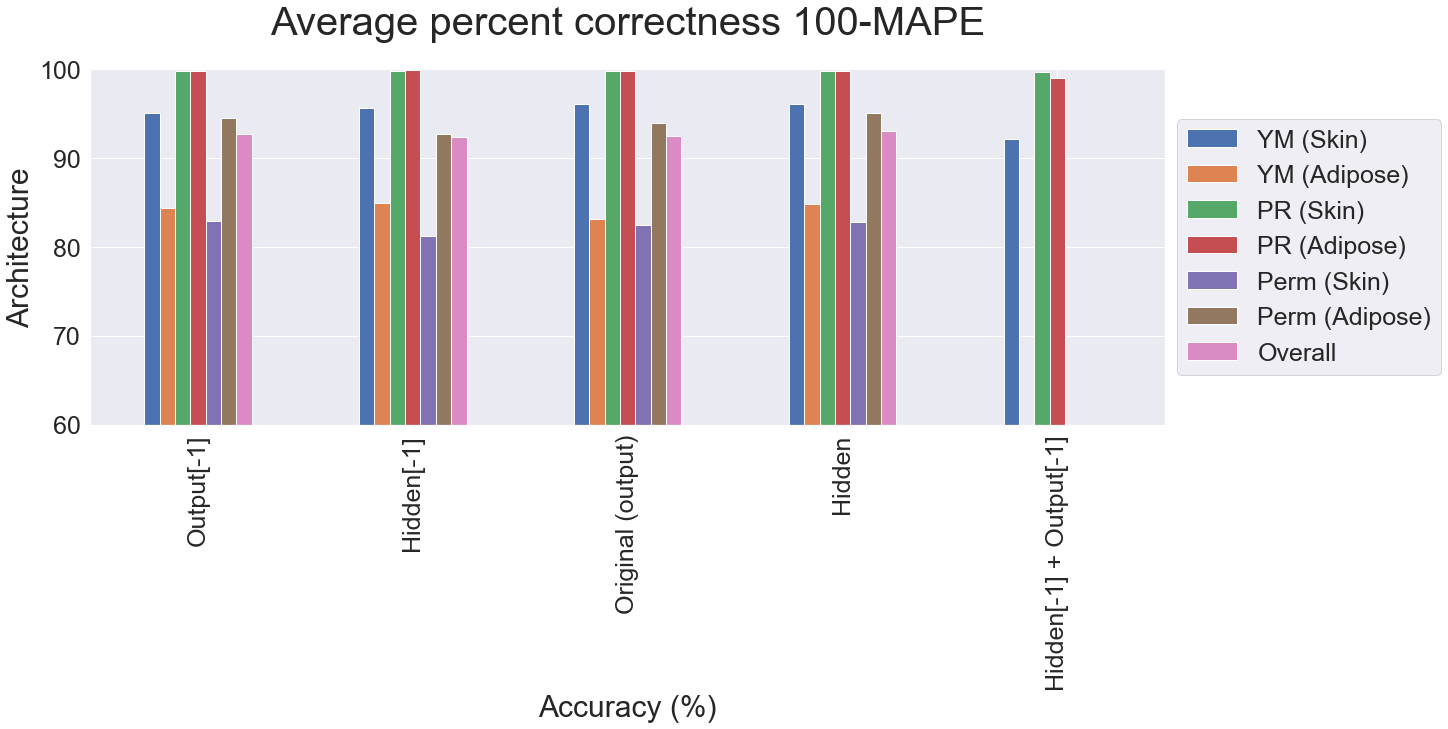

In [245]:
plotParameterBars(df), #file_name="1fcRNNOutsBar.svg")

0
1
1
2
2
3


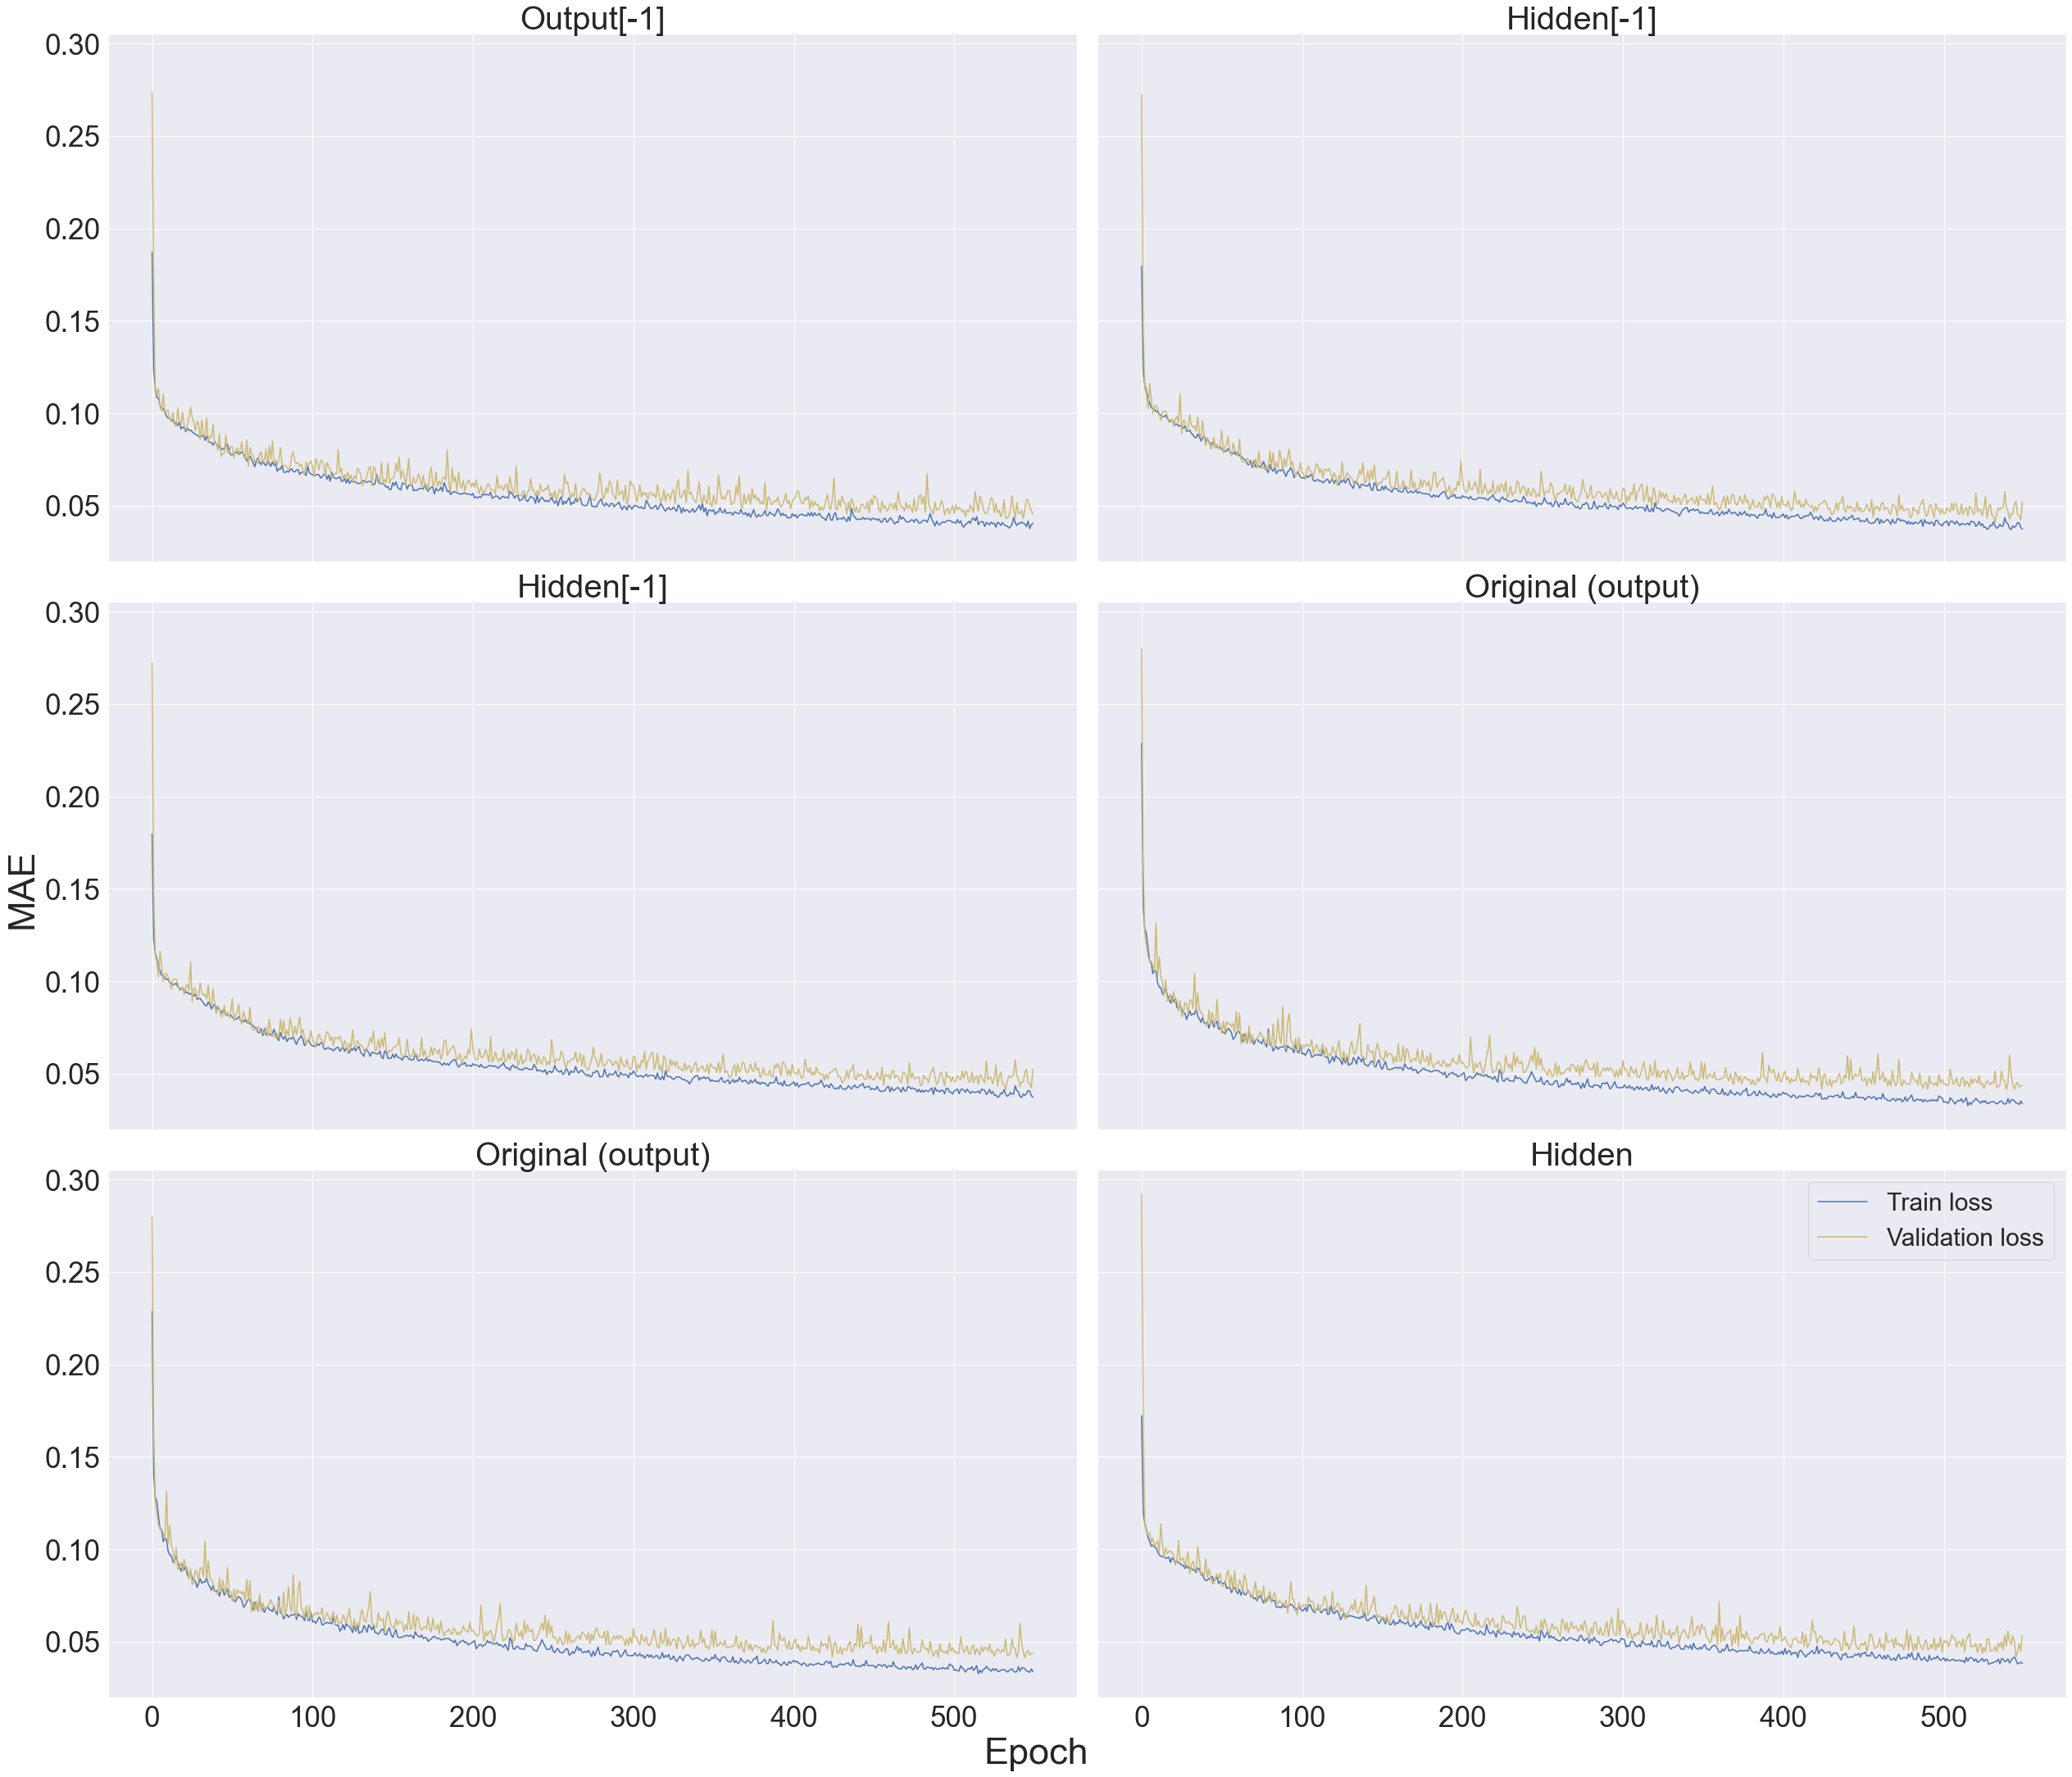

In [93]:
printCurves(names, train_loss, val_loss)

In [38]:
import matplotlib.pyplot as plt
import math
import os

def printCurves(model_names, train_losses, val_losses, epochs=550, fname=None):
    assert len(model_names) == len(train_losses) == len(val_losses)
    
    num_plots = len(model_names)
    num_cols = 2 if num_plots >= 2 else 1
    num_rows = math.ceil(num_plots / num_cols)
    figsize = (20 * num_cols, 15 * num_rows)
    lines = []
    labels = []
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True)
    
    if num_rows == 1 and num_cols == 1:
        axes = [axes]

    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            model_name = model_names[idx]
            train_loss = train_losses[idx]
            val_loss = val_losses[idx]
            epoch_range = range(0, epochs)

            line1, = ax.plot(epoch_range, train_loss, label='Train')
            line2, = ax.plot(epoch_range, val_loss, label='Validation')

            ax.set_title(model_name, fontsize=40)
            ax.tick_params(axis='both', labelsize=35)
            
                        
            if idx == 0:
                lines.extend([line1, line2])
                labels.extend(['Train', 'Validation'])
                
        else:
            ax.axis('off')

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle('Epoch', fontsize=50, x=0.5, y=0.02, horizontalalignment='center', verticalalignment='bottom')
    fig.supylabel('MAE', fontsize=50, x=0.02, y=0.5, horizontalalignment='left', verticalalignment='center', rotation='vertical')
    fig.legend(lines, labels, prop={'size': 50})
    
    if not os.path.exists("../Results/"):
        os.makedirs("../Results/")
    
    if fname:
        plt.savefig(f"../Results/{fname}.svg", format='svg', bbox_inches='tight')
        
    plt.show()
    



In [90]:
print(hidden_train_loss)

None


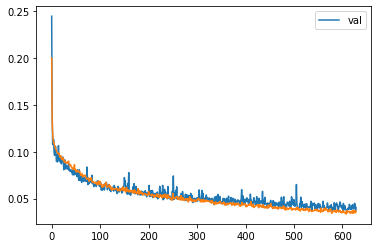

In [128]:
x = list(range(629))
plt.plot(x, hidden_val_loss2, label="val")
plt.plot(x, hidden_train_loss2)
plt.legend()

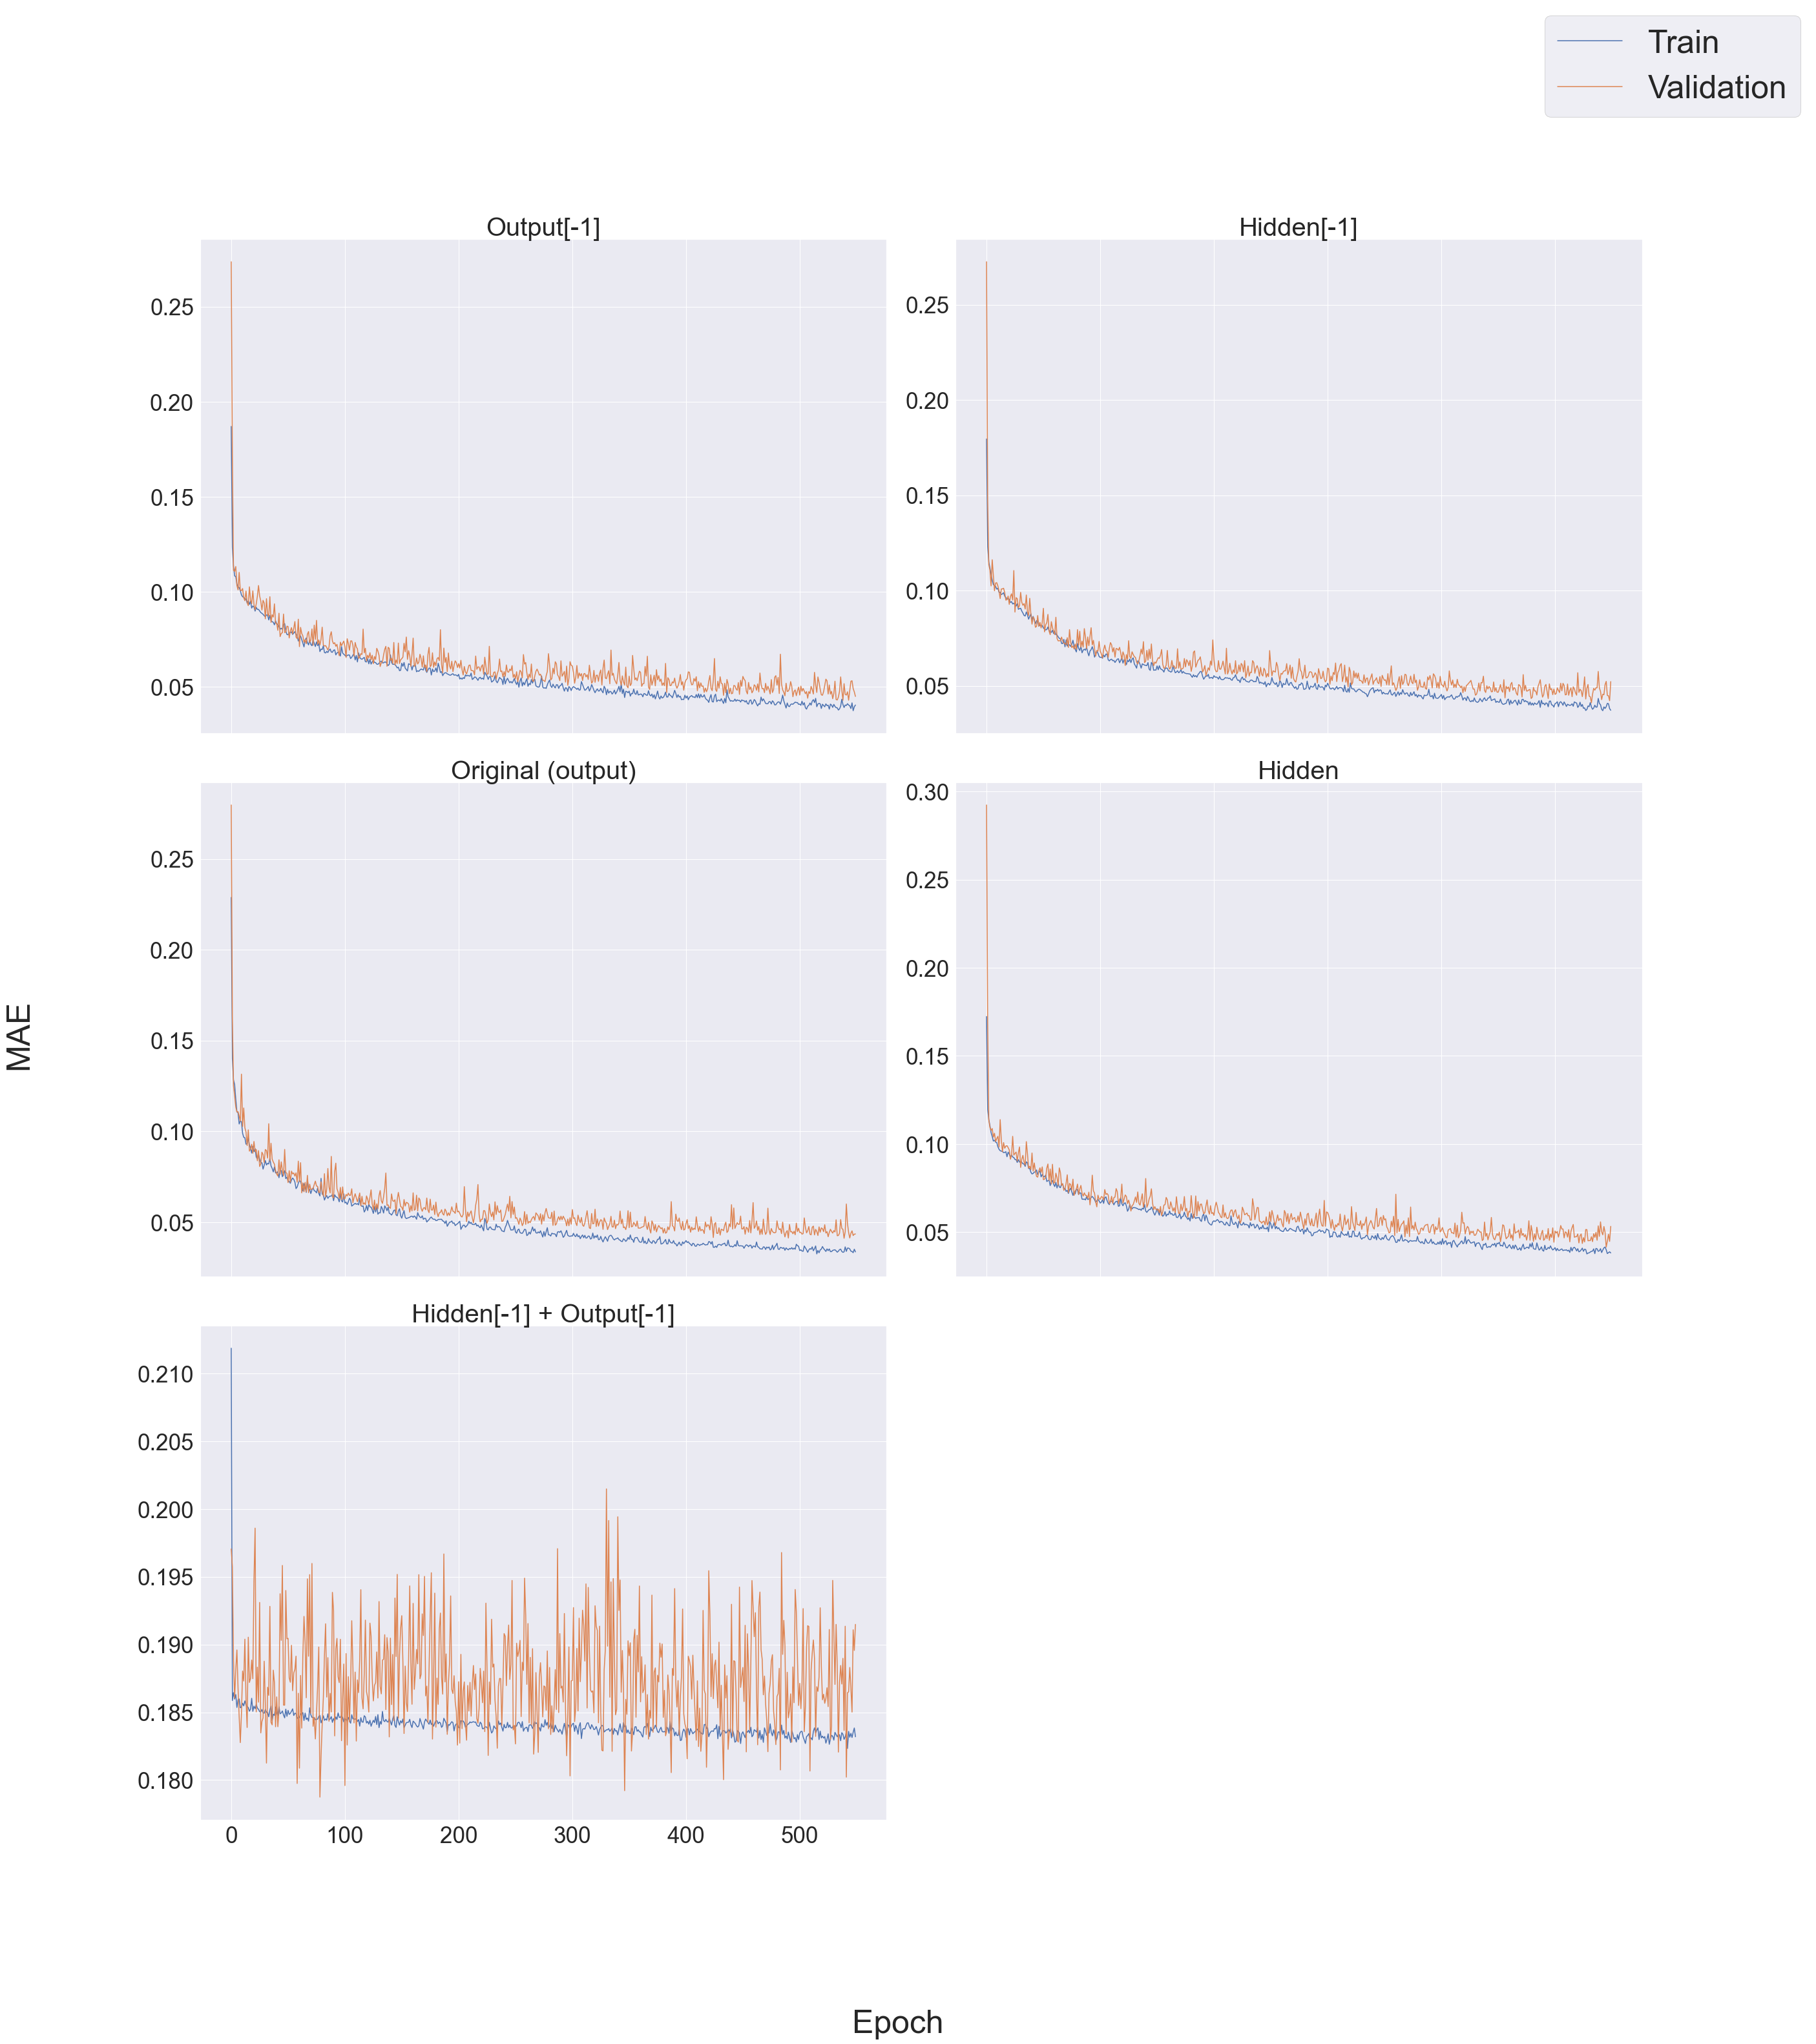

In [247]:
printCurves(names, train_loss, val_loss)#, fname="1fcRNNout")

In [210]:
from matplotlib.font_manager import FontProperties
import six
def save_df(df, fname):
    fig = plt.figure(figsize=(5,5), frameon=False, constrained_layout=True)
    df = df.astype(float)
    df = df.round(2)

    labels = np.concatenate(([df.index.name], df.columns))
    
    text = np.hstack((df.index.values.reshape(-1, 1), df.values))

    df.values
    pd.options.display.float_format = "{:,.2f}".format
    table = plt.table(cellText = text, 
                      colLabels = labels,
                      loc='center',
                     )

    plt.axis('off')
    plt.grid('off')
    
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        
        cell.set_edgecolor("none")

            
        if row %2 != 0:
            cell.set_facecolor('gainsboro')

        

    table.auto_set_font_size(False)
    table.set_fontsize(25)
    table.scale(2.5, 2.5)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    plt.savefig(f'../Results/{fname}.svg', bbox_inches="tight" )
    
    plt.show()

C:\Users\rjsou\AppData\Local\Temp\ipykernel_17668\2488883452.py:38: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'../Results/{fname}.svg', bbox_inches="tight" )
C:\Users\rjsou\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


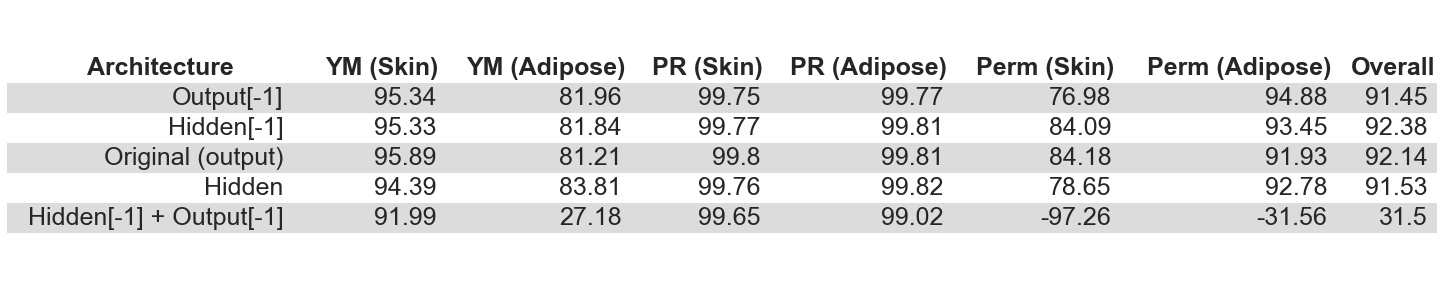

In [211]:
save_df(df, "1FCRNNOutsDF")